# Actividad 4.1
## Ejercicio de clasificación con Keras

---

### Integrantes del Equipo 23:
* Carlos Pano Hernández - A01066264 [Campus Estado de México]
* Marie Kate Palau - A01705711 [Campus Monterrey]
* Edson Ulises Rodríguez Dávalos - A01796057 [Campus CdMx]
* Yohanna Ceballos Salomón - A01795115 [Campus Monterrey]

---

### Escuela de Ingeniería y Ciencias, Tecnológico de Monterrey
**Navegación autónoma (MR4010 - Gpo 10)**

---

#### Profesor Titular:
Dr. David Antonio Torres

#### Profesor Asistente:
Mtra. María Mylen Treviño Elizondo

---

**Sábado 31 de mayo del 2025**

In [41]:
# Importing main libraries
# OS and file handling
import os
import glob

# Data manipulation and numerical computations
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Image processing
import cv2
from skimage.feature import hog

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Deep learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import hog
from tensorflow.keras.utils import plot_model

# Additional Keras imports
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Configure matplotlib for Jupyter
%matplotlib inline

## 2. Loading Image File Paths

The following Python code block is responsible for locating and listing the image files that will be used for training and testing our pedestrian detection model.

In [42]:
people = glob.glob("data/people/*.jpg")
non_people = glob.glob("data/non-people/*.jpg")

print(f"Number of pedestrian images: {len(people)}")
print(f"Number of non-pedestrian images: {len(non_people)}")

Number of pedestrian images: 4246
Number of non-pedestrian images: 4006


## 3. Image Preprocessing: Resizing to a Uniform Dimension

Before we can extract features using Histogram of Oriented Gradients (HOG), it's essential that all our images have the same dimensions. Original images in a dataset often vary in size and aspect ratio.

In [43]:
# Function to resize images to 64x64
def resize_image(image_path):
    img = mpimg.imread(image_path)
    return cv2.resize(img, (64, 64))

# Resize all people images to 64x64
print("Resizing pedestrian images to 64x64...")
for i, image_path in enumerate(people):
    resized = resize_image(image_path)
    cv2.imwrite(image_path, resized)
    
# Resize all non-people images to 64x64 
print("Resizing non-pedestrian images to 64x64...")
for i, image_path in enumerate(non_people):
    resized = resize_image(image_path)
    cv2.imwrite(image_path, resized)

print("All images have been resized to 64x64")

Resizing pedestrian images to 64x64...
Resizing non-pedestrian images to 64x64...
All images have been resized to 64x64


## 4. HOG Feature Extraction and Dataset Preparation

With our images standardized to a uniform size (64x64 pixels), we can now proceed to extract Histogram of Oriented Gradients (HOG) features. This entire process transforms our visual image data into a structured numerical dataset (`X` features and `y` labels), which is the required input format for training our classification model.

In [44]:
people_hog_accum = []
non_people_hog_accum = []

# Process pedestrian images
for i in people:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features and visualization
    people_hog_feature,people_hog_img = hog(img_gray,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    people_hog_accum.append(people_hog_feature)

# Process non-pedestrian images    
for i in non_people:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features and visualization
    non_people_hog_feature,non_people_hog_img = hog(img_gray,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    non_people_hog_accum.append(non_people_hog_feature)
    
# Check dimensions of HOG features before stacking -> IT FAILS IF NOT THE SAME.
people_feature_sizes = [f.shape[0] for f in people_hog_accum]
non_people_feature_sizes = [f.shape[0] for f in non_people_hog_accum]
print("Pedestrian HOG feature sizes:", people_feature_sizes)
print("Non-pedestrian HOG feature sizes:", non_people_feature_sizes)
print("\n")

# Stack all HOG features vertically into single array and convert to float64
X_people = np.vstack(people_hog_accum).astype(np.float64)
X_non_people = np.vstack(non_people_hog_accum).astype(np.float64)

# Create label arrays (1 = pedestrian, 0 = non-pedestrian)
y_people = np.ones(len(X_people))
y_non_people = np.zeros(len(X_non_people))

print(f"Shape of pedestrian HOG features array (X_people): {X_people.shape}")
print(f"Shape of pedestrian labels array (y_people): {y_people.shape}")
print("\n")
print(f"Shape of non-pedestrian HOG features array (X_non_people): {X_non_people.shape}")
print(f"Shape of non-pedestrian labels array (y_non_people): {y_non_people.shape}")

Pedestrian HOG feature sizes: [396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396,

## 5. Data Combination, Splitting, and Neura Model Training

Having extracted HOG features and created corresponding labels for both pedestrian (`_people`) and non-pedestrian (`_non_people`) images, we now need to prepare this data for training our Support Vector Machine (SVM) classifier.

After this code block executes, we will have a trained SVM model (`svc_model`) ready to make predictions.

Shape of combined HOG features array (X): (8252, 396)
Shape of combined labels array (y): (8252,)


Shape of training features (X_train): (6601, 396)
Shape of training labels (y_train): (6601,)
Shape of test features (X_test): (1651, 396)
Shape of test labels (y_test): (1651,)


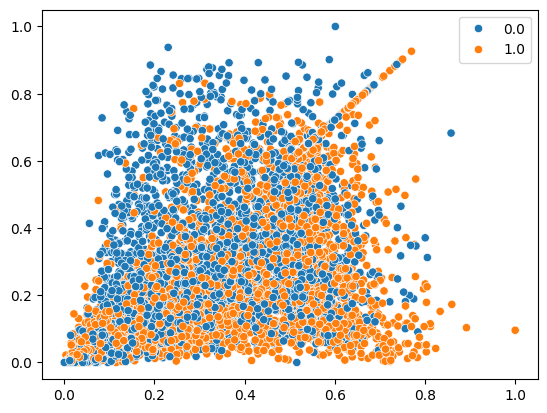

In [45]:
# Stack all features and labels into single arrays
X = np.vstack((X_people,X_non_people))
y = np.hstack((y_people,y_non_people))

print(f"Shape of combined HOG features array (X): {X.shape}")
print(f"Shape of combined labels array (y): {y.shape}")
print("\n")

# Split data into train/test sets (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Scale training data to [0,1] range
scalar = MinMaxScaler()
scalar.fit(X_train)
X_train_scaled = scalar.transform(X_train)

# Scale test data separately
scalar = MinMaxScaler()
scalar.fit(X_test)
X_test_scaled = scalar.transform(X_test)

print(f"Shape of training features (X_train): {X_train.shape}")
print(f"Shape of training labels (y_train): {y_train.shape}")
print(f"Shape of test features (X_test): {X_test.shape}") 
print(f"Shape of test labels (y_test): {y_test.shape}")

# Plot first 2 features of training data
sns.scatterplot(x=X_train_scaled[:, 0], y=X_train_scaled[:, 1], hue=y_train)
plt.show()

## 6. Neural Network Model Creation and Training

Having prepared our HOG feature data, we will now create and train a neural network classifier. We will use a sequential model with multiple dense layers for this binary classification task.

The model architecture consists of:
- Input layer: 396 neurons (matching HOG feature vector size) with ReLU activation
- Hidden layer 1: 256 neurons with ReLU activation
- Hidden layer 2: 128 neurons with ReLU activation 
- Hidden layer 3: 64 neurons with ReLU activation
- Output layer: 1 neuron with sigmoid activation for binary classification

In [46]:
# Create sequential model
model = Sequential()

# Input layer - matches HOG feature size
model.add(Dense(units=396, input_dim=396, activation='relu'))

# Hidden layers with decreasing units
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))

# Binary classification output
model.add(Dense(units=1, activation='sigmoid'))

# Configure training parameters
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train with 20% validation split
hist = model.fit(x=X_train_scaled, 
                y=y_train,
                validation_split=0.2,
                verbose=1, 
                batch_size=32,
                epochs=50)

Epoch 1/50


/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8973 - loss: 0.2684 - val_accuracy: 0.9478 - val_loss: 0.1343
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9464 - loss: 0.1396 - val_accuracy: 0.9553 - val_loss: 0.1097
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9519 - loss: 0.1212 - val_accuracy: 0.9561 - val_loss: 0.1112
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9565 - loss: 0.1054 - val_accuracy: 0.9614 - val_loss: 0.1012
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9646 - loss: 0.0896 - val_accuracy: 0.9614 - val_loss: 0.1065
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.0886 - val_accuracy: 0.9682 - val_loss: 0.0875
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9647 - loss: 0.0863 - val_accuracy: 0.9463 - val_loss: 0.1267
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9651 - loss: 0.0879 - val_accuracy: 0.9546 - val_

# 7. Model Visualization and Analysis

After training our neural network, we will visualize its architecture and analyze its performance.

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 396)            │       157,212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 256)            │       101,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 900,185 (3.43 MB)

 Trainable params: 300,061 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 600,124 (2.29 MB)

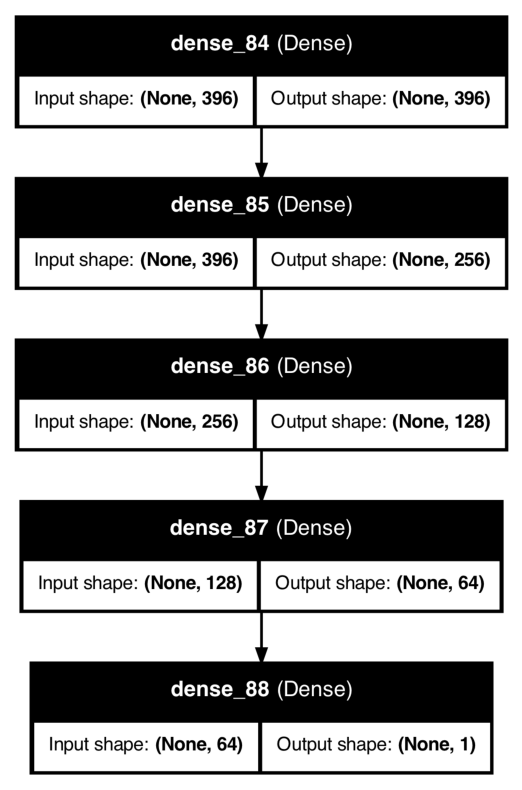

In [47]:
# Print model layers, parameters and shapes
model.summary()

# Generate and save model architecture diagram
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the architecture diagram
plt.figure(figsize=(10,10))
img = plt.imread('model_architecture.png')
plt.imshow(img)
plt.axis('off') # Hide axes
plt.show()

# 8. Model Visualization and Analysis

After training our neural network, we will visualize its architecture and analyze its performance through:
- Model architecture summary and diagram
- Training vs validation accuracy plots
- Training vs validation loss curves
- Training metrics progression analysis

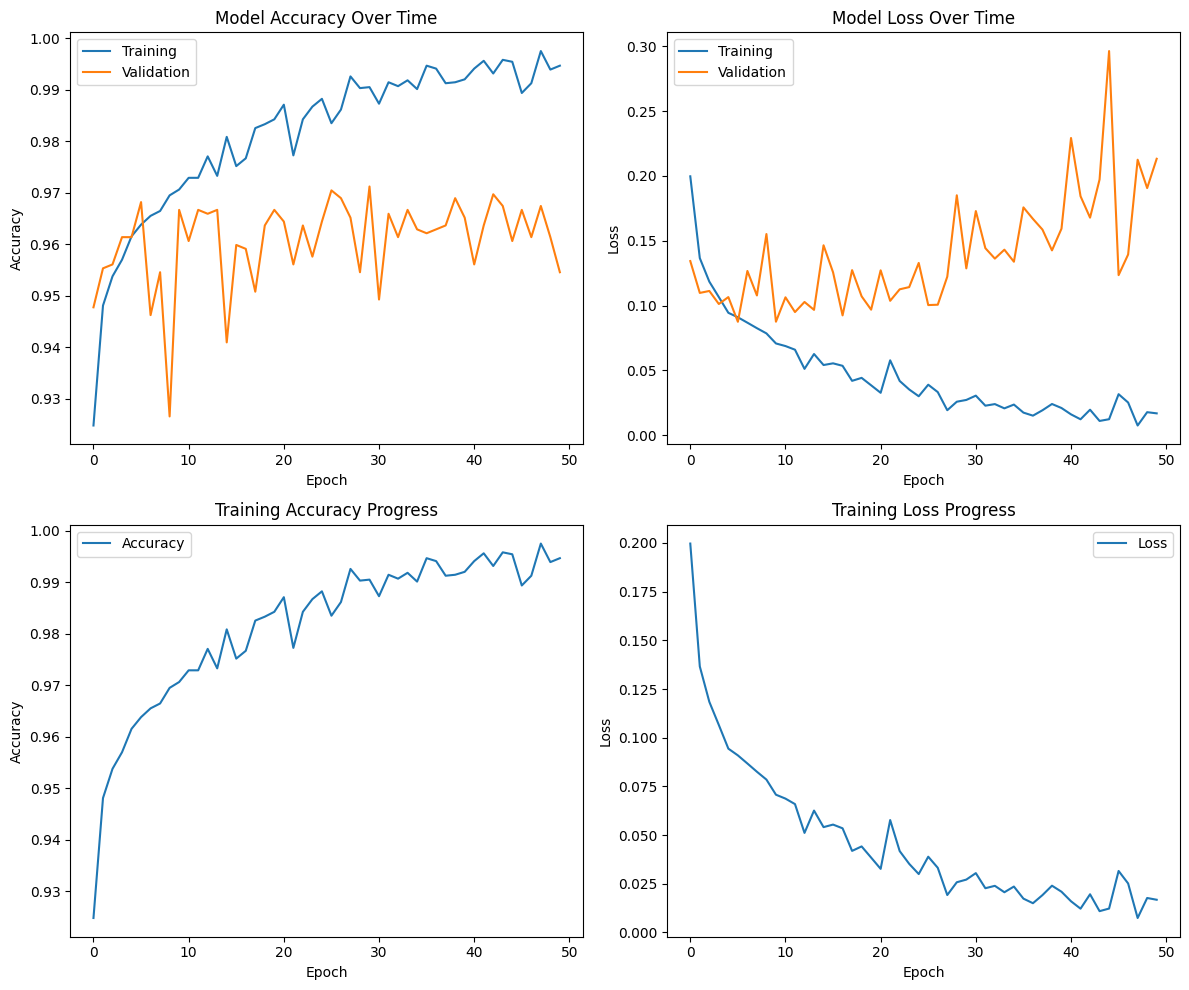

In [48]:
# Create a 2x2 subplot figure for model metrics visualization
plt.figure(figsize=(12,10))

# Plot training vs validation accuracy
plt.subplot(2,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Model Accuracy Over Time')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Plot training vs validation loss
plt.subplot(2,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Model Loss Over Time')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot training accuracy trend
plt.subplot(2,2,3)
plt.plot(hist.history['accuracy'])
plt.legend(['Accuracy'])
plt.title('Training Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Plot loss trend
plt.subplot(2,2,4)
plt.plot(hist.history['loss'])
plt.legend(['Loss'])
plt.title('Training Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# 9. Model Evaluation: Predictions and Confusion Matrix
Now that our Neural Network model has been trained, the next crucial step is to evaluate its performance on the unseen test data (`X_test`, `y_test`).

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


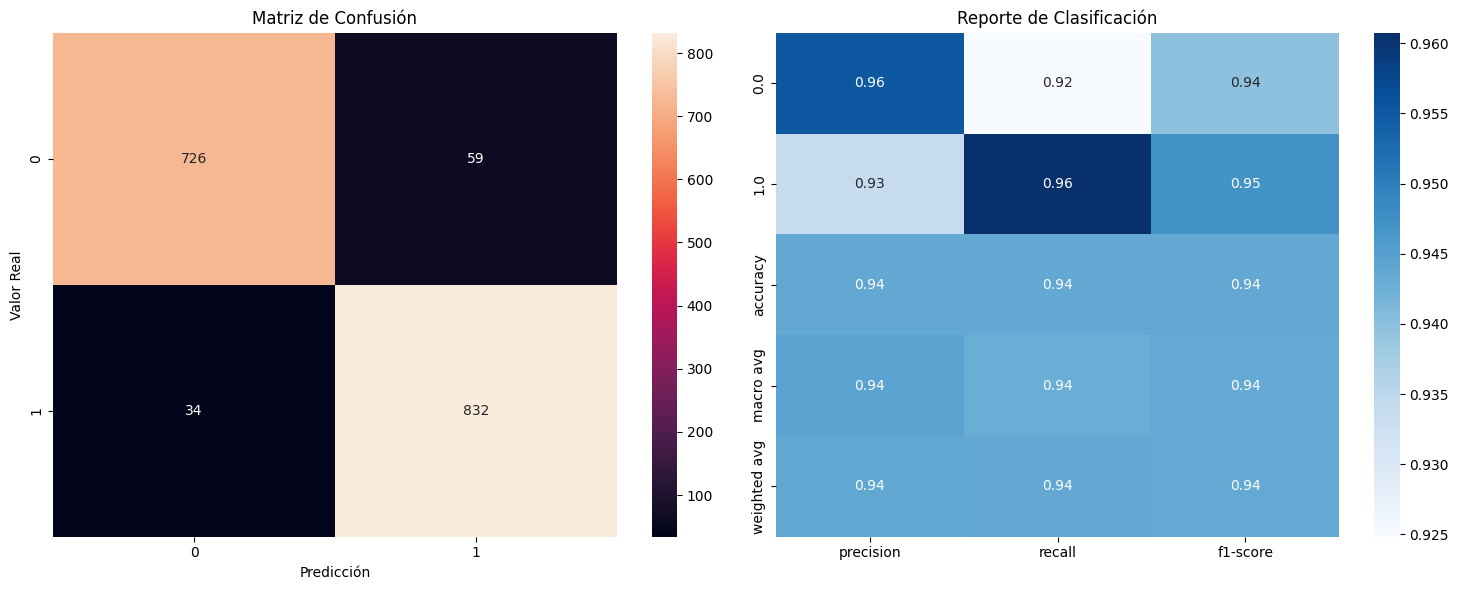


Classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       785
         1.0       0.93      0.96      0.95       866

    accuracy                           0.94      1651
   macro avg       0.94      0.94      0.94      1651
weighted avg       0.94      0.94      0.94      1651



In [49]:
# Make predictions
y_predict = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Create figure with two subplots side by side
plt.figure(figsize=(15,6))

# Plot confusion matrix on the left
plt.subplot(1,2,1)
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')

# Plot classification report on the right
plt.subplot(1,2,2)
report = classification_report(y_test, y_predict, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Reporte de Clasificación')

plt.tight_layout()
plt.show()

# Also print the classification report for detailed viewing
print("\nClassification report:")
print(classification_report(y_test, y_predict))


/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


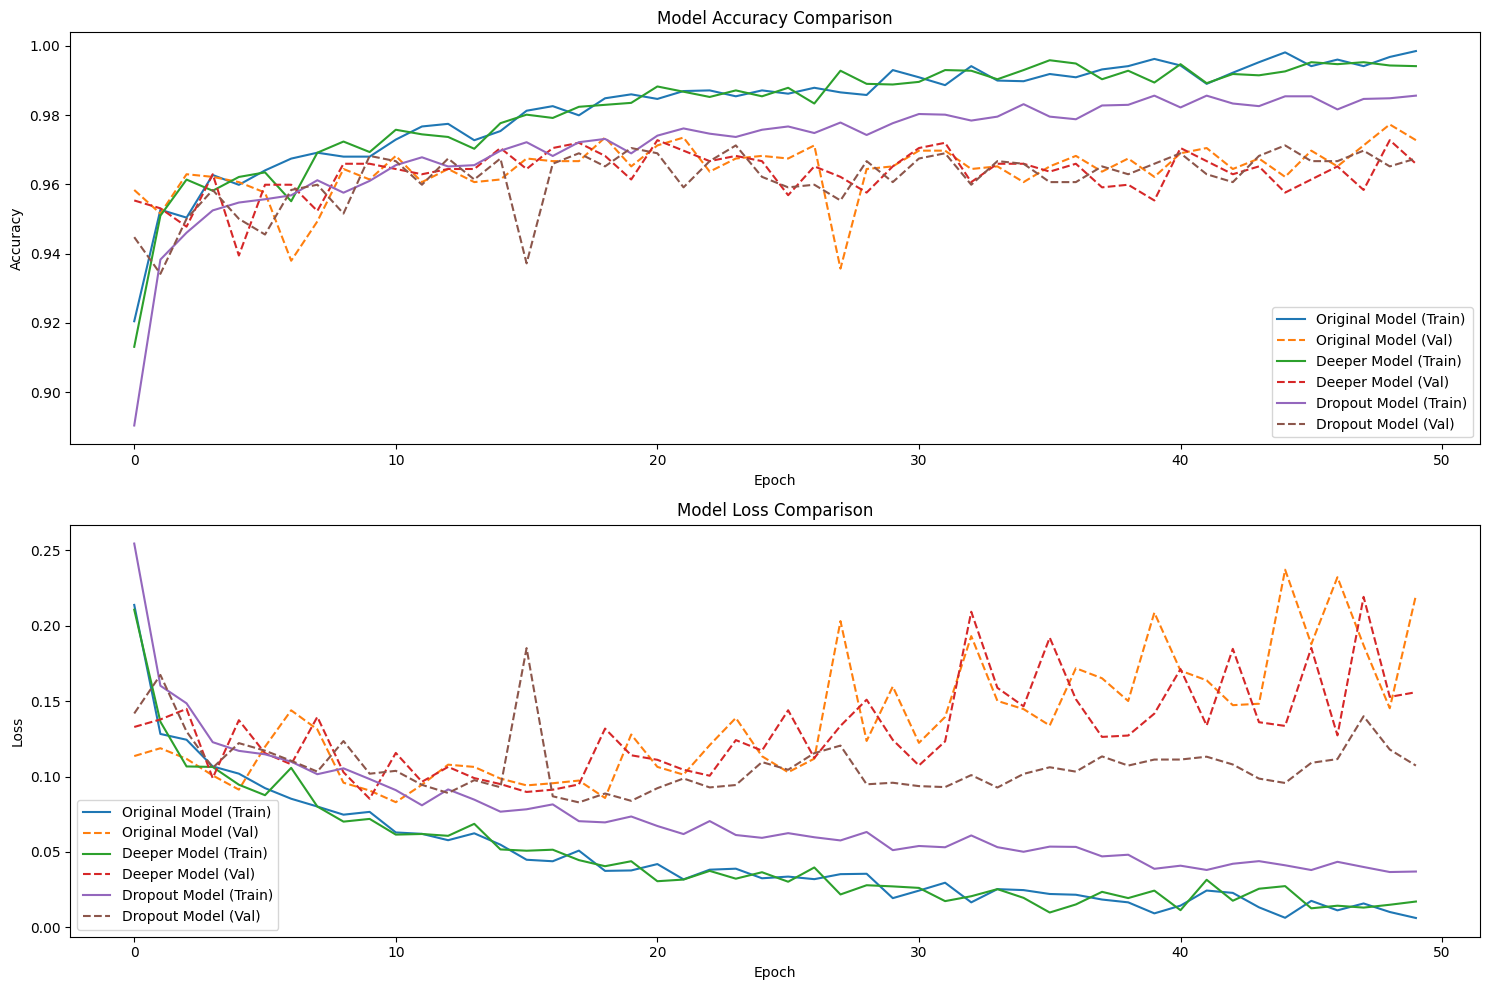

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step


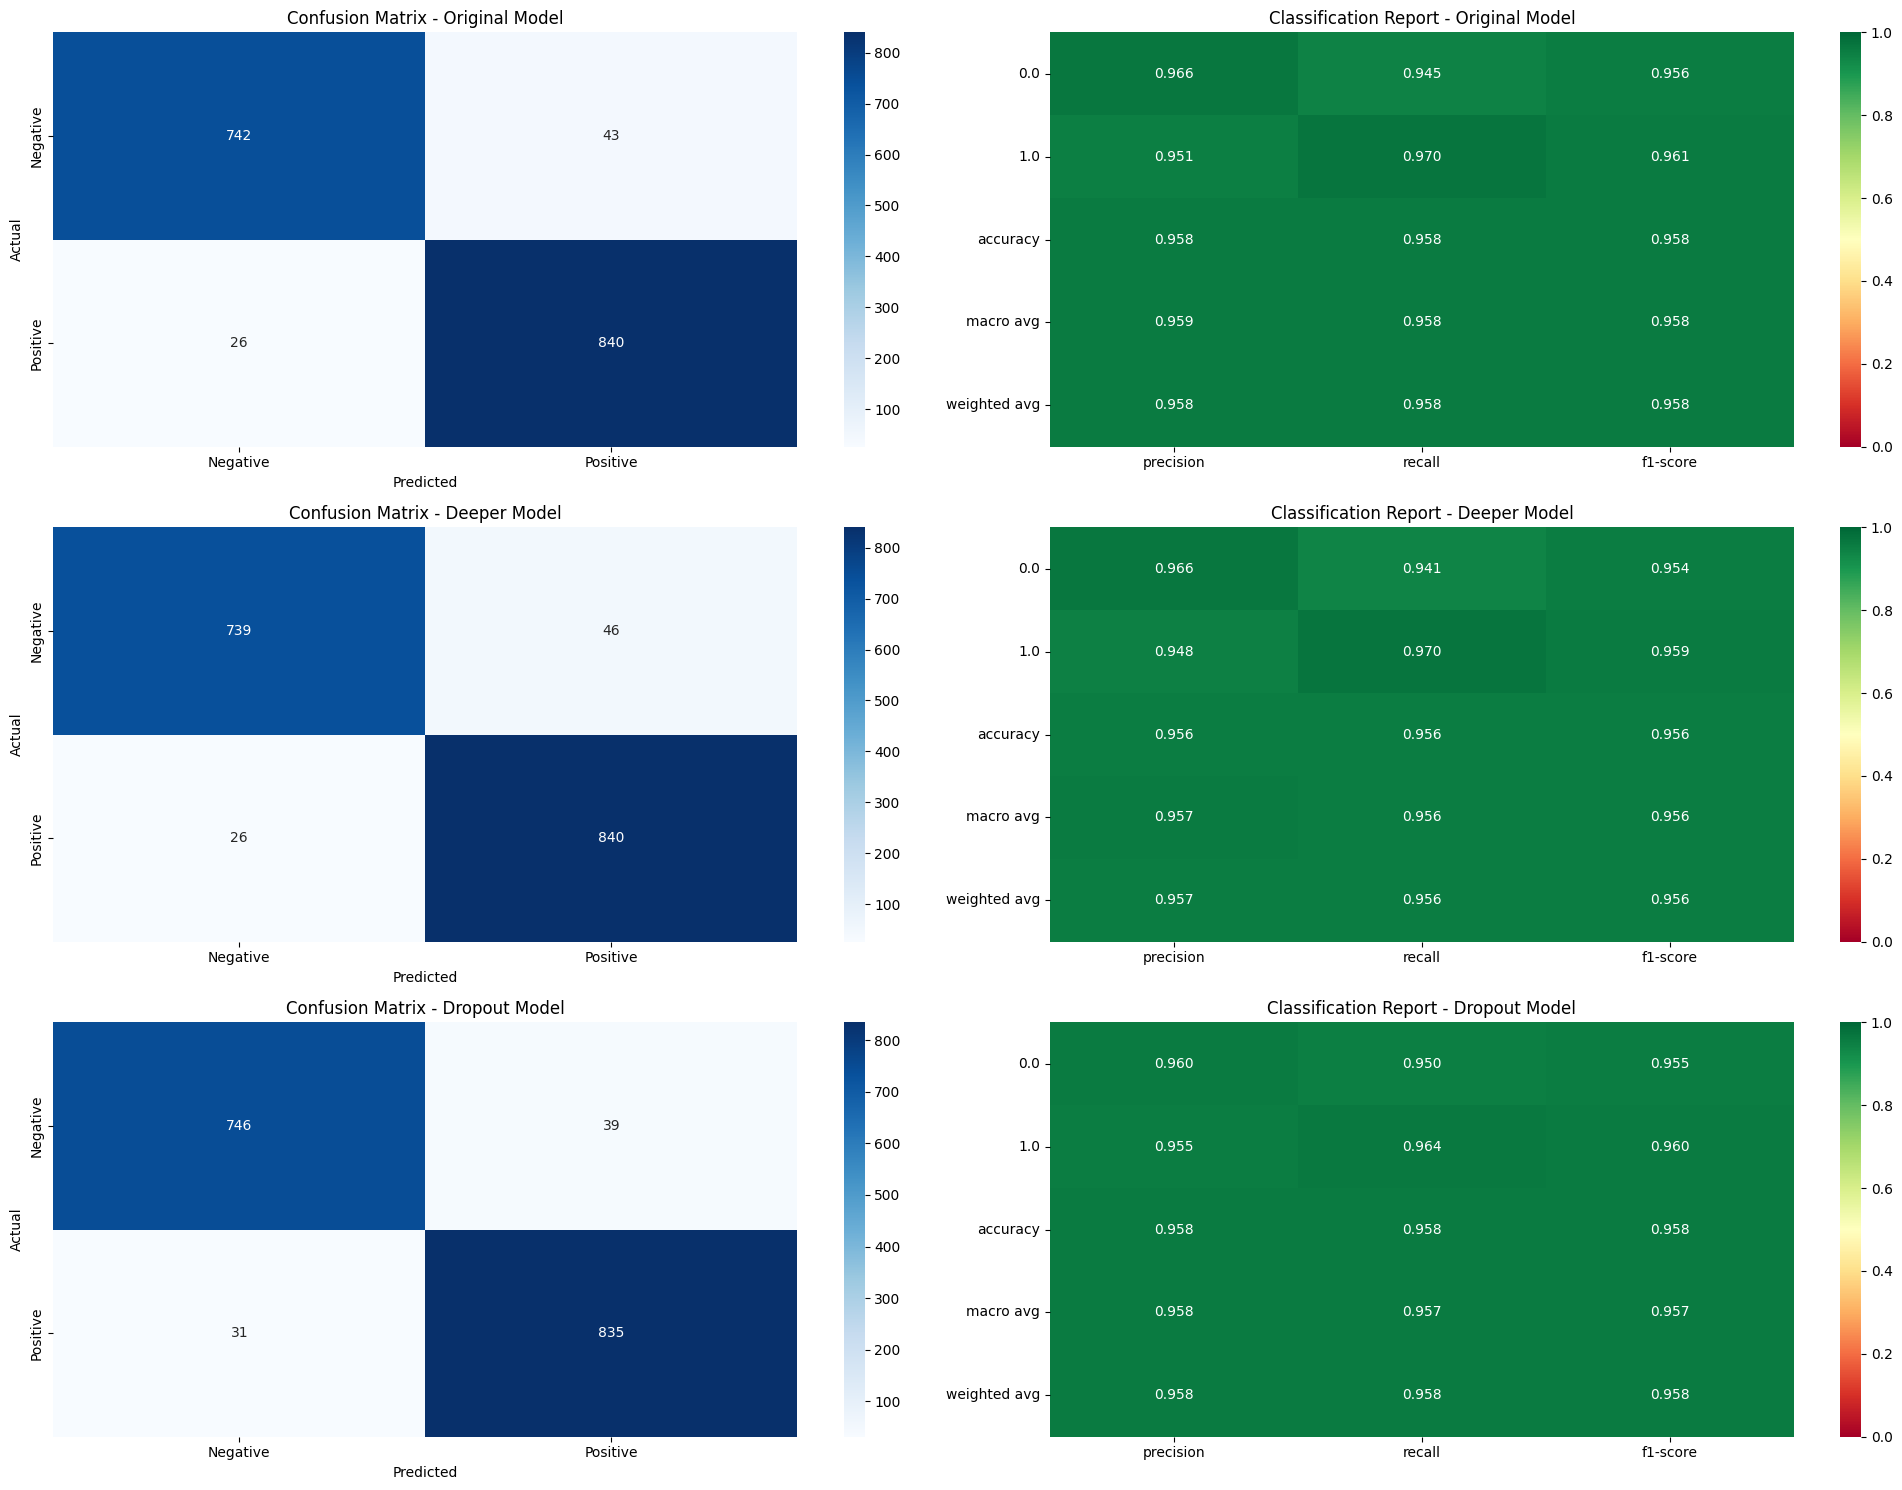

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step

Classification report for Original Model:
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       785
         1.0       0.95      0.97      0.96       866

    accuracy                           0.96      1651
   macro avg       0.96      0.96      0.96      1651
weighted avg       0.96      0.96      0.96      1651

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step

Classification report for Deeper Model:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       785
         1.0       0.95      0.97      0.96       866

    accuracy                           0.96      1651
   macro avg       0.96      0.96      0.96      1651
weighted avg       0.96      0.96      0.96      1651

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step

Classification report for Dropout Model:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.9

In [50]:
# Train multiple models with different architectures
models = []
histories = []

# Model 1 - Original architecture
model1 = Sequential([
    Dense(396, activation='relu', input_shape=(396,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist1 = model1.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
models.append(('Original Model', model1))
histories.append(('Original Model', hist1))

# Model 2 - Deeper architecture
model2 = Sequential([
    Dense(512, activation='relu', input_shape=(396,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist2 = model2.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
models.append(('Deeper Model', model2))
histories.append(('Deeper Model', hist2))

# Model 3 - With dropout layers
model3 = Sequential([
    Dense(396, activation='relu', input_shape=(396,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist3 = model3.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
models.append(('Dropout Model', model3))
histories.append(('Dropout Model', hist3))

# Visualize training history for all models
plt.figure(figsize=(15, 10))

# Plot accuracy comparison
plt.subplot(2, 1, 1)
for name, hist in histories:
    plt.plot(hist.history['accuracy'], label=f'{name} (Train)')
    plt.plot(hist.history['val_accuracy'], label=f'{name} (Val)', linestyle='--')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss comparison
plt.subplot(2, 1, 2)
for name, hist in histories:
    plt.plot(hist.history['loss'], label=f'{name} (Train)')
    plt.plot(hist.history['val_loss'], label=f'{name} (Val)', linestyle='--')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate all models
plt.figure(figsize=(20, 15))
for idx, (name, model) in enumerate(models):
    # Make predictions
    y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
    
    # Plot confusion matrix
    plt.subplot(3, 2, 2*idx + 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Plot classification report
    plt.subplot(3, 2, 2*idx + 2)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T
    sns.heatmap(report_df, annot=True, cmap='RdYlGn', fmt='.3f',
                vmin=0, vmax=1)
    plt.title(f'Classification Report - {name}')

plt.tight_layout()
plt.show()

# Print detailed classification reports
for name, model in models:
    y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
    print(f"\nClassification report for {name}:")
    print(classification_report(y_test, y_pred))
